In [1]:
import numpy as np
from entitybert import cohesion, selection
from entitybert.selection import (
    EntityDto,
    EntityGraph,
    EntityTree,
    FileGraph,
    calc_simple_valid_classes_df,
    is_filename_valid,
)
from sentence_transformers import SentenceTransformer

import torch
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import umap

from sklearn.decomposition import KernelPCA

In [2]:
MODEL = SentenceTransformer(".models/EntityBERT-train-v2b3__1e-5-cont")
DB_PATH = ".data/student_dbs/Team2_Final.db"
FILENAME = "src/main/Driver.java"

In [3]:
def create_adjacency_matrix(nodes, edges):
    n = len(nodes)
    node_index = {node: i for i, node in enumerate(nodes)}
    adj_matrix = np.zeros((n, n))

    for edge in edges:
        i, j = node_index[edge[0]], node_index[edge[1]]
        adj_matrix[i, j] = 1
        adj_matrix[j, i] = 1  # because the graph is undirected

    return adj_matrix


def normalize_adjacency_matrix(adj_matrix):
    degrees = adj_matrix.sum(axis=1)
    degrees[degrees == 0] = 1  # prevent division by zero
    norm_matrix = adj_matrix / degrees[:, np.newaxis]
    return norm_matrix


def compute_kernel_matrix(nodes, edges, alpha=0.85):
    adj_matrix = create_adjacency_matrix(nodes, edges)
    norm_matrix = normalize_adjacency_matrix(adj_matrix)
    identity_matrix = np.eye(len(nodes))
    kernel_matrix = np.linalg.inv(identity_matrix - alpha * norm_matrix)
    return kernel_matrix


def compute_commute_time_kernel(nodes, edges):
    adj_matrix = create_adjacency_matrix(nodes, edges)
    degree_matrix = np.diag(adj_matrix.sum(axis=1))
    laplacian_matrix = degree_matrix - adj_matrix
    laplacian_pseudo_inverse = np.linalg.pinv(laplacian_matrix)
    return laplacian_pseudo_inverse

In [4]:
classes_df = calc_simple_valid_classes_df(DB_PATH)
classes_df.sort_values("entities", ascending=False)[250:300]

,loc,entities,content
filename,,,


In [5]:
conn = selection.open_db(DB_PATH)
file_graph = FileGraph.load_from_db(conn.cursor())
trees = EntityTree.load_from_db(conn.cursor())
graph = EntityGraph.load_from_db(conn.cursor())
tree = trees[FILENAME]
print(tree.text())

package main;

import answers.AnswerSheet;
import answers.Tabulator;
import question.QuestionBuilder;
import questionnaires.Survey;
import questionnaires.Test;
import ui.Console;
import ui.GUI;
import ui.UI;

import java.util.*;

public class Driver {

    private Survey currentTestOrSurvey;
    private Tabulator tabulator;
    private AnswerSheet answerSheet;
    private AnswerSheet answerKey;

    private QuestionBuilder questionBuilder;
    private UI ui;
    private int menu;

    public Driver() {
        this.ui = null;
        this.menu = 0;
        this.questionBuilder = new QuestionBuilder();
    }

    private static final Map<Integer, String> mainMenuOptions = new HashMap<>();
    private static final Map<Integer, String> surveyOptions = new HashMap<>();
    private static final Map<Integer, String> testOptions = new HashMap<>();
    private static final Map<Integer, String> questionOptions = new HashMap<>();

    public void run(String[] args) {
        buildMenus();
      

In [6]:
entity_ids = tree.nontrivial_leaf_siblings()[0]
texts = [tree.entity_text(id) for id in entity_ids]
embeddings = cohesion.calc_embeddings(MODEL, texts)
print(type(embeddings))
print(embeddings.shape)

<class 'torch.Tensor'>
torch.Size([22, 768])


In [7]:
def plot_embeddings_2d(embeddings: np.ndarray):
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y)
    for (id, i, j) in zip(entity_ids, x, y):
        plt.text(i, j, tree[id].name)
    plt.show()

In [8]:
edges = graph.subgraph(set(entity_ids)).to_pairs()

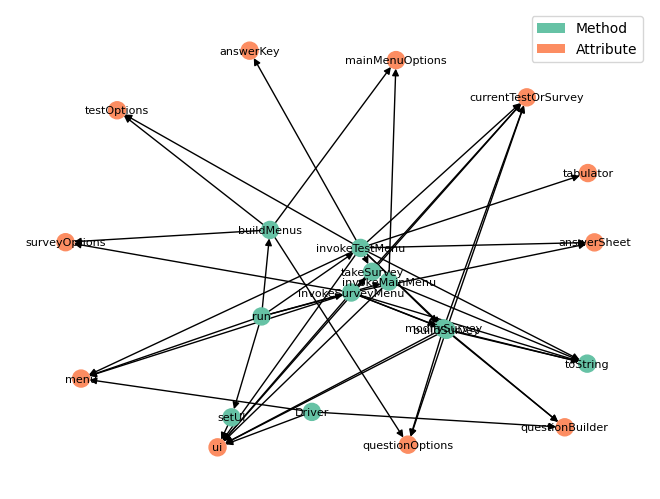

In [9]:
palette = sns.color_palette("Set2")


def to_color(entity: EntityDto) -> tuple[float, float, float]:
    if cohesion.is_method(entity):
        return palette[0]
    if cohesion.is_attribute(entity):
        return palette[1]
    raise RuntimeError()


G = nx.DiGraph()
G.add_nodes_from(entity_ids)
G.add_edges_from(edges)

pos = nx.spring_layout(G)
node_colors = [to_color(tree[id]) for id in entity_ids]
labels = {id: tree[id].name for id in entity_ids}
nx.draw(
    G,
    pos,
    with_labels=True,
    labels=labels,
    node_color=node_colors,
    font_size=8,
    node_size=150,
)

# Create a legend
plt.legend(
    handles=[
        Patch(facecolor=palette[0], label="Method"),
        Patch(facecolor=palette[1], label="Attribute"),
    ]
)

# Display the plot
# plt.title("Layout")
plt.show()

In [10]:
embeddings_2d = umap.UMAP(n_components=2).fit_transform(embeddings.cpu().numpy())
embeddings_2d.shape

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


(22, 2)

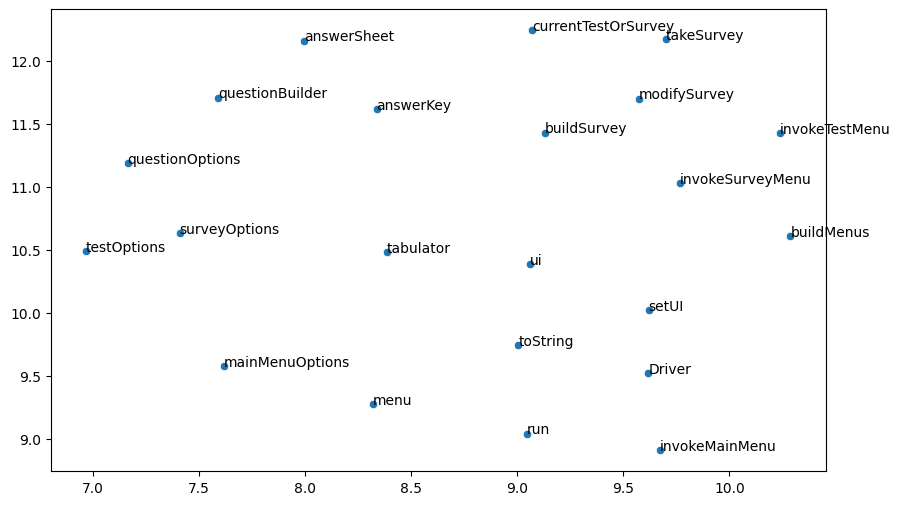

In [11]:
plot_embeddings_2d(embeddings_2d)

In [12]:
kernel1 = compute_kernel_matrix(entity_ids, edges, alpha=0.85)
print(kernel1.shape)
kernel2 = compute_commute_time_kernel(entity_ids, edges)
print(kernel2.shape)

(22, 22)
(22, 22)


In [13]:
# enhanced = torch.matmul(torch.from_numpy(kernel2.astype(np.float32)).to(embeddings.device), embeddings)
# enhanced_2d = umap.UMAP(n_components=2).fit_transform(enhanced.cpu().numpy())
# plot_embeddings_2d(enhanced_2d)

In [14]:
# plot_embeddings_2d(np.matmul(kernel1, embeddings_2d))

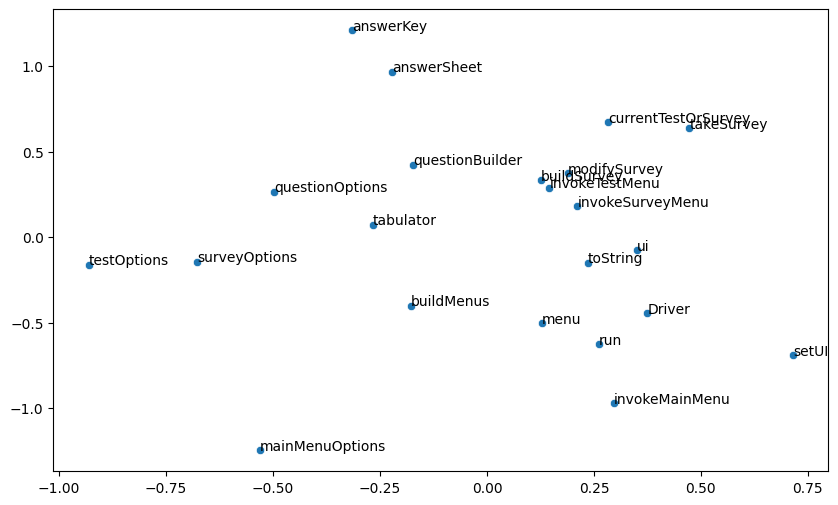

In [15]:
plot_embeddings_2d(np.matmul(kernel2, embeddings_2d))